In [1]:
import dataclasses

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import sys; sys.path.append("../../../foggy-statslib")
import foggy_statslib.core as fsc
import foggy_statslib.fin as fsf

# MEAN-VARIANCE-OPTIMAL ALLOCATION

author: [@sparshsah](https://github.com/sparshsah)

Using the ideas from [my portfolio food pyramid](https://github.com/sparshsah/foggy-demo/blob/main/demo/finance/pflio-food.pdf)
and [1-800-STYLS-4-U](https://github.com/sparshsah/foggy-demo/blob/main/demo/finance/styles4u.ipynb),
we can construct a "model portfolio".
I will run up the big categories from bottom to top of the pyramid,
suggesting a sample vehicle for accessing it and ballparking its ex-ante Sharpe.

Let us agree on the following conventions:
* All PM stats (Sharpe, ER, Vol) are
    * Long-term
    * Annualized
    * Excess-of-cash
        * A note here: "Excess of cash" can be rewritten as "excess of real short rates plus inflation". And in theory, first-order (and all else equal), real bond yields should not vary with inflation. (Of course the "all else equal" breaks down as soon as you go deeper than the first order. The Fed _usually_ hikes nominal rates to let the economy cool down when inflation spikes, but it doesn't have to, and it can deploy massive Quantitative Easing in an attempt to keep rates suppressed if it wants to. Thus the Fed can allow inflation to eat into nominal rates, effecting a drop in real rates -- As long as it's willing to risk George Soros calling their bluff.) Similarly, excess-of-cash ER's should not vary with interest rates. For example, take stocks: When the Fed hikes, everyone cranks up the discount rate they're using in their DCF models, and today's prices fall so that go-forward gross-of-cash returns rise exactly enough to keep go-forward excess-of-cash returns steady. (Of course, again the "all else equal" breaks down: When ZIRP ended in 2023, we saw the fallout... The change in rates environment had the outsize effect of actually zero'ing out some companies that might otherwise have zombie'd along in perpetuity. But we're trying to be first-order here.) By no-arbitrage, futures must follow suit, and indeed they do: If you go long a futures contract on a stock index in a high-rates environment, your cash margin will be earning a lot, but at the same time you'll have to agree to be on the hook for a higher futures price. I haven't convinced myself of the effect on a self-financing long-short portfolio, but I can see an argument that even here, borrowing fees will rise in tandem with interest rates, preserving balance in the universe. However -- With all that said -- In practice -- AQR [finds](https://www.aqr.com/Insights/Research/Alternative-Thinking/Honey-the-Fed-Shrunk-the-Equity-Premium) that in high-rate environments, traditional risky asset classes tend to realize lower-than-average excess returns. (The pathway for this could be as simple as usury limits, which don't loosen up just because the Fed has hiked rates.) On the other hand, strategies that they call "cash-plus" (that is, first-order "self-financing" strategies like managed futures or market-neutral equity, where your NAV sits as cash in margin and/or brokerage accounts) don't seem to lose their edge. So there's at least one manager out there recommending that, when rates rise, you might consider allocating away from traditional risky asset classes and toward alternatives and/or just straight cash.
* If I leave it unqualified, the stat is gross-of-fee, but net-of-tcost-and-financing. So, it doesn't reflect what your manager is going to charge you for it, but it does reflect prime-brokerage commissions, shorting expenses, etc.
* If I say "net", the stat is net of both fees and tcost-and-financing. So, it reflects management and performance fees paid to the manager in addition to the fees described above.
* Here is an important nuance: When you look at the "expense ratio" of a mutual fund, you are looking at a mix of management fees and tcost-and-financing. Sometimes you'll even see a "gross expense ratio" and a lower "net expense ratio", with the latter reflecting a voluntary reimbursement by the manager. For example, if you see a gross expense ratio of 102bps and a net expense ratio of 99bps, then the manager is currently volunteering to reimburse you at an annualized 3bps (perhaps in this case because they desire some marketing benefit associated keeping an expense ratio less than 100bps). But this number does not compare cleanly from fund to fund, and it varies over time even when the manager has made no change to their policy. So, when you want to translate a gross-of-fee net-of-tcost-and-financing Sharpe to a net-net Sharpe, penalize by the _adjusted_ expense ratio. For a more in-depth explanation, see Morningstar's excellent article ["One Expense Ratio to Rule Them All"](https://www.morningstar.com/funds/one-expense-ratio-rule-them-all).

## Sample vehicles

* Beta: We could use the [AQR Multi-Asset Risk-Parity Mutual Fund (AQRNX)](https://funds.aqr.com/funds/multi-asset/aqr-multi-asset-fund/aqrnx), which targets 10% vol, charging 1.06% adjusted expense ratio.
    * Runner-up: [Bridgewater All-Weather Fund](https://www.bridgewater.com/research-and-insights/the-all-weather-story). Pros: Matches AQR's version in terms of diversification across asset classes and geographies, and All-Weather's track record is actually a smidge _longer_. I also just like the story a bit better. Cons: Not marketed to retail investors. Sad!
* Macro: We could use the [AQR Managed Futures Mutual Fund (AQMNX)](https://funds.aqr.com/funds/alternatives/aqr-managed-futures-strategy-fund/aqmnx), which targets 10% vol, charging 1.51% adjusted expense ratio. The core strategy here is trend-following, plus some other stuff they're coy about in the prospectus but which I can confirm is good.
* [Styles](https://github.com/sparshsah/foggy-demo/blob/main/demo/finance/styles4u.ipynb): We could use the [Vanguard Market-Neutral Equity Mutual Fund (VMNFX)](https://investor.vanguard.com/investment-products/mutual-funds/profile/vmnfx), which targets (I infer) 6% vol, charging 0.20% adjusted expense ratio.
    * Runner-up: QSPNX (which is diversified across asset classes and geographies) or QMNNX (which not only adds more alpha-like signals, but also remains diversified across geographies despite---like VMNFX---being just stocks). Cons: They're both much more expensive in the face of a dirt-cheap 20bps. And really, the deciding factor is that we have too much AQR risk in our model portfolio already.
* Special Situations: We could use the [AQR Diversified Arbitrage Mutual Fund (ADANX)](https://funds.aqr.com/funds/alternatives/aqr-diversified-arbitrage-fund/adanx), which targets a bit less than 5% vol but budgets for a bit heavier-than-usual tails (so let's call it effectively 6% vol), charging 1.50% adjusted expense ratio.
    * Runner-up: [Driehaus Event-Driven Fund (DEVDX)](https://www.driehaus.com/funds/driehaus-event-driven-fund). Pros: Targets slightly higher vol, and is slightly cheaper. Cons: They don't do convertible arbitrage, and on top of that they're just not well-hedged (0.70-correlated to SPX, vs ADANX's 0.45).

In [2]:
# my stylized ex-ante Sharpes
sharpes = pd.Series({
    "beta": 0.80,
    # start with a base of 0.40, and add +0.10 reward for alphas i like e.g. AQR's GSS Factor Momentum
    "macro": 0.50,
    # start with a base of 0.40, and subtract -0.10 penalty for underdiversification (VMNFX is just stocks and just US)
    "styles": 0.30,
    "spec_sits": 0.40,
})
vols = pd.Series({
    "beta": 0.10,
    "macro": 0.10,
    "styles": 0.06,
    "spec_sits": 0.06,
})
fees = pd.Series({
    "beta": 0.0106,
    "macro": 0.0151,
    "styles": 0.0020,
    "spec_sits": 0.0150,
})

# assume uncorrelated
corr = pd.DataFrame(
    np.identity(len(sharpes)),
    index=sharpes.index,
    columns=sharpes.index,
)

# calculate
ers_net = sharpes*vols - fees
sharpes_net = ers_net / vols
stats = pd.DataFrame({
    "sharpe_net": sharpes_net.apply(lambda v: f"{v:.2f}"),
    "er_net": ers_net.apply(lambda v: f"{v:.1%}"),
    "vol": vols.apply(lambda v: f"{v:.0%}"),
})
stats

,sharpe_net,er_net,vol
beta,0.69,6.9%,10%
macro,0.35,3.5%,10%
styles,0.27,1.6%,6%
spec_sits,0.15,0.9%,6%


In [3]:
# notional allocation (i.e. $'s, not risk) in a unit-levered portfolio
w = pd.DataFrame(
    {
        "simple_mvo": fsf._simple_mvo(
            sharpe_vector=sharpes_net,
            vol_vector=vols,
            corr_matrix=corr,
        )[0],
        "thumb_on_scaled": pd.Series(
            {
                "beta": 0.40,
                "macro": 0.25,
                "styles": 0.20,
                "spec_sits": 0.15,
            }
        ),
    }
)
w

,simple_mvo,thumb_on_scaled
beta,0.399437,0.40
macro,0.200870,0.25
styles,0.255804,0.20
spec_sits,0.143889,0.15


In [4]:
pd.DataFrame({
    env: fsf._get_exante_pm_stats_of_w_as_ser(
        w,
        er_vector=ers_net,
        cov_matrix=fsc.compose_cov_matrix(vol_vector=vols, corr_matrix=corr),
        fmt=True,
    )
    for (env, w) in w.items()
})

,simple_mvo,thumb_on_scaled
sharpe,0.83,0.83
er,4.01%,4.10%
vol,4.81%,4.95%


# CONSERVATIVE VS AGGRESSIVE RISK-TAKING

In [5]:
@dataclasses.dataclass(frozen=True)
class History:
    """
    Fields:
        r: pd.DataFrame, The geometric returns.
            Index = sims, Columns = years.
        px: pd.DataFrame, The price index.
        dd: pd.DataFrame, Current geometric drawdown level.
    """
    r: pd.DataFrame = dataclasses.field(default_factory=pd.DataFrame)
    px: pd.DataFrame = dataclasses.field(default_factory=pd.DataFrame)
    dd: pd.DataFrame = dataclasses.field(default_factory=pd.DataFrame)
    
    def __init__(self, r: np.ndarray) -> None:
        r = pd.DataFrame(
            r,
            index=pd.Index(range(r.shape[0]), name="sim"),
            columns=pd.Index(range(r.shape[1]), name="year"),
        )
        r.loc[:, 0] = 0
        r = r.clip(lower=-1)
        # override frozen dataclass by reaching into internals
        object.__setattr__(self, "r", r)
        del r
        px = (1 + self.r).cumprod(axis="columns")
        object.__setattr__(self, "px", px)
        del px
        dd = self.px / self.px.expanding().max() - 1
        object.__setattr__(self, "dd", dd)

In [6]:
def sim_history(
    er: float = 0.10,
    vol: float = 0.10,
    nyears: int = 50,
    nsims: int = 1_000,
) -> History:
    r = np.random.default_rng(seed=42).normal(
        loc=er, scale=vol, size=(nsims, nyears),
    )
    history = History(r=r)
    return history

# "SPX" -- really 15-17% vol, but left tails bring it to like 20% vol
history_aggressive = sim_history(er=0.10, vol=0.20)
# "diversified"
history_conservative = sim_history(er=0.05, vol=0.05)
avg_px = pd.DataFrame(
    {
        "aggressive": history_aggressive.px.median(),
        "conservative": history_conservative.px.median(),
    },
)

/var/folders/j1/k5f4073s6wj4tz_zy4ts1l0r0000gn/T/ipykernel_34176/1458476947.py:20: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  r.loc[:, 0] = 0
/var/folders/j1/k5f4073s6wj4tz_zy4ts1l0r0000gn/T/ipykernel_34176/1458476947.py:20: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  r.loc[:, 0] = 0


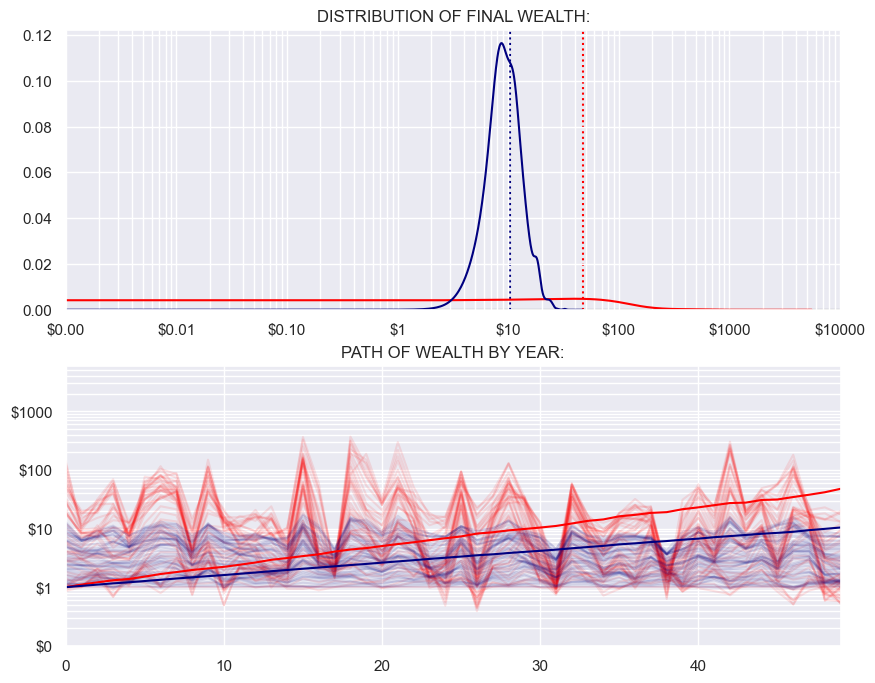


Quantiles of final wealth:
quantile        0th    5th   10th   25th 50th  75th  90th  95th   100th
aggressive    $0.73  $4.71  $8.76    $18  $48  $110  $272  $452  $3,691
conservative  $3.79  $5.92  $6.78  $8.19  $10   $13   $16   $18     $32

Quantiles of worst drawdown:
quantile        0th    5th   10th  25th  50th  75th  90th  95th 100th
aggressive    -100%  -100%  -100%  -99%  -99%  -97%  -92%  -88%    0%
conservative   -88%   -81%   -79%  -75%  -68%  -59%  -48%  -43%    0%

Quantiles of worst annual return:
quantile       0th   5th  10th  25th  50th  75th  90th  95th 100th
aggressive    -78%  -52%  -47%  -41%  -34%  -28%  -24%  -22%  -11%
conservative  -17%  -11%   -9%   -8%   -6%   -5%   -4%   -3%   -0%


In [7]:
_, ax = plt.subplots(nrows=2)
# terminals
fsc.plot(
    history_aggressive.px.iloc[:, -1],
    kind="density",
    color="red",
    axvline_locs=[avg_px["aggressive"].iloc[-1]],
    axvline_styles=[":"],
    axvline_colors=["red"],
    # plt
    ax=ax[0],
)
fsc.plot(
    history_conservative.px.iloc[:, -1],
    kind="density",
    color="navy",
    axvline_locs=[avg_px["conservative"].iloc[-1],],
    axvline_styles=[":"],
    axvline_colors=["navy"],
    # plt
    title="DISTRIBUTION OF FINAL WEALTH:",
    ylim_bottom=0,
    logx=True,
    xlim_left=0.001,
    xticklabels_fmt=lambda x, _: f"${x:.2f}" if x < 0.99 else f"${x:.0f}",
    xlabel="",
    ax=ax[0],
)
# paths
fsc.plot(
    history_aggressive.px,
    color="red",
    alpha=0.10,
    # plt
    ax=ax[1],
)
fsc.plot(
    history_conservative.px,
    color="navy",
    alpha=0.10,
    ax=ax[1],
)
fsc.plot(
    avg_px,
    color=["red", "navy"],
    # plt
    title="PATH OF WEALTH BY YEAR:",
    yticklabels_fmt=lambda y, _: f"${y:.0f}",
    ylim_bottom=0.10,
    logy=True,
    xlabel="",
    legend=False,
    figsize=(10, 8),
    ax=ax[1],
)
# show
print()
plt.show()

# stats
qq = [0, 0.05, 0.10, 0.25, 0.50, 0.75, 0.90, 0.95, 1]
print("\nQuantiles of final wealth:")
print(
    pd.DataFrame(
        {
            "aggressive": history_aggressive.px.iloc[:, -1].quantile(qq),
            "conservative": history_conservative.px.iloc[:, -1].quantile(qq),
        },
        index=pd.Index(qq, name="quantile"),
    )
    .applymap(lambda x: f"${x:,.2f}" if x < 10 else f"${x:,.0f}")
    .rename(index=lambda pctl: f"{pctl * 100:,.0f}th").T
)
print("\nQuantiles of worst drawdown:")
print(
    pd.DataFrame(
        {
            "aggressive": history_aggressive.dd.min(axis="columns").quantile(qq),
            "conservative": history_conservative.dd.min(axis="columns").quantile(qq),
        },
        index=pd.Index(qq, name="quantile"),
    )
    .applymap(lambda x: f"{x:.0%}")
    .rename(index=lambda pctl: f"{pctl * 100:,.0f}th").T
)
print("\nQuantiles of worst annual return:")
print(
    pd.DataFrame(
        {
            "aggressive": history_aggressive.r.min(axis="columns").quantile(qq),
            "conservative": history_conservative.r.min(axis="columns").quantile(qq),
        },
        index=pd.Index(qq, name="quantile"),
    )
    .applymap(lambda x: f"{x:.0%}")
    .rename(index=lambda pctl: f"{pctl * 100:,.0f}th").T
)